In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as pc
from scipy.optimize import minimize
from utils import *

In [7]:
#make one big dataframe with arbitrage for every timestamp
arbitrage_df = pd.DataFrame()
for date in get_forwards()['TimeStamp'].astype(str).unique():
    arbitrage_df = pd.concat([arbitrage_df,get_arbitrage_opportunities_in_forwards(get_forwards(date),date)])
arbitrage_df

""


In [2]:
test_forecast= pd.read_csv('data/test_forecast.csv',sep=',')
test_forecast['timestamp'] = pd.to_datetime(test_forecast['ds'], errors='coerce')
#arbitrage_correction('2021-01-04',test_forecast,lambda_1 = 0)

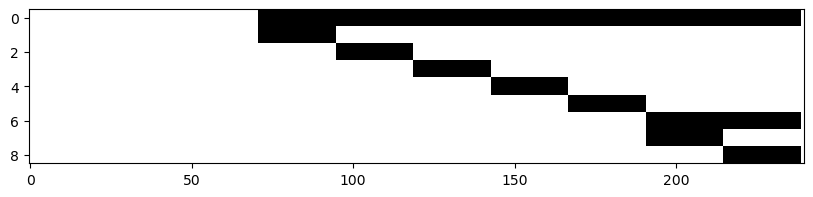

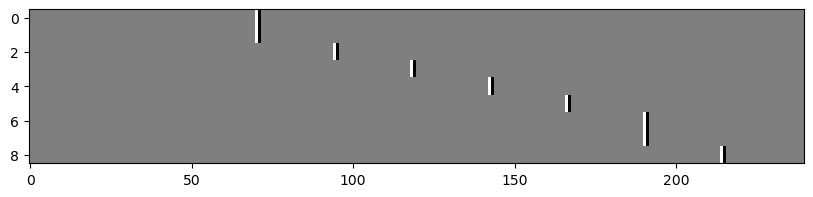

In [3]:
#visualize constraints
start = test_forecast['timestamp'].min()
end = test_forecast['timestamp'].max()
timestamp = '2021-01-04'
A, b, D= get_restrictions(timestamp,start,end)
plt.figure(figsize=(10, 2))  # Adjust the figure size for better readability
plt.imshow(A, cmap='binary', aspect='auto')  # 'auto' aspect ratio scales with the matrix shape
plt.show()
plt.figure(figsize=(10, 2))  # Adjust the figure size for better readability
plt.imshow(D, cmap='binary', aspect='auto')  # 'auto' aspect ratio scales with the matrix shape
plt.show()

In [4]:
x,arb = arbitrage_correction('2021-01-04',test_forecast,lambda_1 = 0.08)
print("Initial border smoothness: ",np.sum(np.square(D@test_forecast.yhat)))
print("Final border smoothness: ",np.sum(np.square(D@x)))

No arbitrage opportunities found in forwards
Optimum found


Initial border smoothness:  81.54129589714606
Final border smoothness:  424.10982183414006


In [27]:
x,arb = arbitrage_correction('2021-01-04',test_forecast,lambda_1 = 0)
print("Initial border smoothness: ",np.sum(np.square(D@test_forecast.yhat)))
print("Final border smoothness: ",np.sum(np.square(D@x)))

No arbitrage opportunities found in forwards
Optimum found


Initial border smoothness:  81.54129589714606
Final border smoothness:  691.1893724805303


In [8]:
forwards = get_forwards('2021-01-04', start = '2021-01-04', end = '2025-01-05')
timestamps, prices = partition_forwards(forwards)
data = forwards
# Initialize plot
fig = go.Figure()
unique_identifiers = data['Identifier'].unique()
color_map = {identifier: color for identifier, color in zip(unique_identifiers, pc.qualitative.Plotly)}
added_identifiers = set()

# Plot original data
for index, row in data.iterrows():
    show_legend = row['Identifier'] not in added_identifiers
    fig.add_trace(go.Scatter(
        x=[row['Begin'], row['End']],
        y=[row['Settlement'], row['Settlement']],
        mode='lines',
        name=row['Identifier'] if show_legend else None,
        showlegend=show_legend,
        line=dict(color=color_map[row['Identifier']])
    ))
    added_identifiers.add(row['Identifier'])

# Add new forward lines
temporary_identifier = "New_Forward_Line"
color_map[temporary_identifier] = pc.qualitative.Plotly[len(color_map) % len(pc.qualitative.Plotly)]
for i in range(len(prices)):
    fig.add_trace(go.Scatter(
        x=[timestamps[i], timestamps[i + 1]],
        y=[prices[i], prices[i]],
        mode='lines',
        name=temporary_identifier if i == 0 else None,  # Add legend only once
        showlegend=(i == 0),
        line=dict(color=color_map[temporary_identifier], dash="dot")  # Optional: use dashed line style
    ))

for ts in timestamps:
    fig.add_trace(go.Scatter(
        x=[ts, ts],
        y=[0, max(data['Settlement'].tolist())],
        mode='lines',
        line=dict(color='gray', dash='dot'),
        showlegend=False
    ))

# Show the plot
fig.show()
